# Mandel's Problem

* Author: Jhabriel Varela
* E-mail: jhabriel.varela@uib.no
* Date: 26.03.2019
* Institution: PMG - UiB - Norway

## Description of the problem

Mandel's problem is a well known two-dimensional benchmark problem which admits an analytical solution. It was originally presented by Mandel [[1](#ref)], who developed an analytical solution for the pressure. Later, Abousleiman [[2](#ref)] extended the solutions for the displacement and vertical stress. 

Mandel's problem consists of a poroelastic slab of length $2a$ in the horizontal direction and $2b$ in the vertical direction. The slab is sandwiched by two rigid plates (see left figure). Initially, two loads of equal magnitude and opposite signs are applied to the slab at the top and bottom of the domain. This sudden compression triggers a consolidation process whitin the slab, causing the pressure to increase up to a maximum value and then to monotonically decrease up to zero. 

Interestingly enough, the pressure and the horizontal component of the displacement only depend on the x-coordinate, and the vertical component of the displacement only depend on the y-coordinate. Nevertheless, we encounter a tricky situation when it comes to the treatment of boundary conditions. Since the loads are applied through the rigid plates, neither the traction nor the displacement are known at the north boundary. To cope with this situation, we exploit the symmetry of the problem, which allow us to focus only on the quarter positive domain (see also left figure). 

Since the solution is symmetric, we can represent the computational domain as in the right figure, where the boundary conditions for the mechanics and flow are shown. Moreover, instead of prescribing a load, we use the analytical solution (see below) to impose a vertical displacement at the north of the domain at each time step. This will allow us to recover the pressure and displacement fields, which in turn can be compared with the known solution. 

![](mandels_prob.png)

## The analytical solution

Here we compute the analytical solution of the quarter domain Mandel's problem. A thorough discussion can be found in [[3](ref)].

The pressure and the displacements are given by:

$$
p(x,t) = \frac{2FB(1+\nu_u)}{3a} \sum_{n=1}^{\infty} \frac{\sin{\alpha_n}}{\alpha_n - \sin{\alpha_n}\cos{\alpha_n}} \left(\cos{\frac{\alpha_n x}{a} - \cos{\alpha_n}}\right) \exp{\left(-\alpha_n^2c_ft/a^2\right)},
$$

$$
u_x(x,t) = \left[\frac{F\nu}{2\mu a} - \frac{F\nu_u}{\mu a} \sum_{n=1}^{\infty} \frac{\sin{\alpha_n}\cos{\alpha_n}}{\alpha_n - \sin{\alpha_n \cos{\alpha_n}}} \exp{\left(-\alpha_n^2c_ft/a^2\right)}\right] x + \frac{F}{\mu} \sum_{n=1}^{\infty} \frac{\cos{\alpha_n}}{\alpha_n - \sin{\alpha_n}\cos{\alpha_n}} \sin{\frac{\alpha_n x}{a}} \exp{\left(-\alpha_n^2c_ft/a^2\right)},
$$

$$
u_y(y,t) = \left[\frac{-F(1-\nu)}{2\mu a} + \frac{F(1-\nu_u)}{\mu a}  \sum_{n=1}^{\infty} \frac{\sin{\alpha_n}\cos{\alpha_n}}{\alpha_n - \sin{\alpha_n \cos{\alpha_n}}} \exp{\left(-\alpha_n^2c_ft/a^2\right)}\right] y,
$$

where $F$ is the applied vertical force $[N/m]$, $B$ is the Skempton's coefficient $[-]$, $\nu$ and $\nu_u$ are drained and undrained Poisson's coefficients $[-]$, $\mu$ is the shear modulus $[Pa]$, $c_f$ is the fluid diffusivity coefficient $[m^2/s]$ and $a$ and $b$ are the horizontal and vertical lengths of the (quarter) domain $[m]$. We note that, for the above equations, $\alpha_n$ represents the positive roots to the (non-linear) equation

$$
\tan{\alpha_n} = \frac{1-\nu}{\nu_u-\nu} \alpha_n,
$$

which must be solved numerically.

The initial conditions are given by:

$$
    p(x,0) = \frac{FB(1+\nu_u)}{3a},
$$

$$
    u_x(x,0) = \frac{F\nu_u}{2\mu a} x,
$$

$$
    u_y(y,0) = \frac{-F(1-\nu_u)}{2\mu a} y.
$$

## Importing modules

In [1]:
import numpy as np
import scipy.sparse as sps
import matplotlib.pyplot as plt
import scipy.optimize as opt
import porepy as pp
from porepy.ad.forward_mode import Ad_array
np.set_printoptions(precision=4, suppress = True)

## Functions

In [2]:
def mandel_solution(g,Nx,Ny,times,F,B,nu_u,nu,c_f,mu_s):
     
    # Some needed parameters
    a = np.max(g.face_centers[0])        # a = Lx
    x_cntr = g.cell_centers[0][:Nx]      # [m] vector of x-centers
    y_cntr = g.cell_centers[1][::Nx]     # [m] vector of y-centers

    # Solutions to tan(x) - ((1-nu)/(nu_u-nu)) x = 0
    """
    This is somehow tricky, we have to solve the equation numerically in order to
    find all the positive solutions to the equation. Later we will use them to 
    compute the infinite sums. Experience has shown that 200 roots are more than enough to
    achieve accurate results. Note that we find the roots using the bisection method.
    """
    f      = lambda x: np.tan(x) - ((1-nu)/(nu_u-nu))*x # define the algebraic eq. as a lambda function
    n_series = 200           # number of roots
    a_n = np.zeros(n_series) # initializing roots array
    x0 = 0                   # initial point
    for i in range(0,len(a_n)):
        a_n[i] = opt.bisect( f,                           # function
                             x0+np.pi/4,                  # left point 
                             x0+np.pi/2-10000*2.2204e-16, # right point (a tiny bit less than pi/2)
                             xtol=1e-30,                  # absolute tolerance
                             rtol=1e-15                   # relative tolerance
                           )        
        x0 += np.pi # apply a phase change of pi to get the next root

    # Creating dictionary to store analytical solutions
    mandel_sol = dict()
    mandel_sol['p'] = np.zeros((len(times),len(x_cntr)))
    mandel_sol['u_x'] = np.zeros((len(times),len(x_cntr)))
    mandel_sol['u_y'] = np.zeros((len(times),len(y_cntr)))
    mandel_sol['sigma_yy'] = np.zeros((len(times),len(x_cntr)))

    # Terms needed to compute the solutions (these are constants)  
    p0 = (2 * F * B * (1 + nu_u)) / (3*a)
    ux0_1 = ((F*nu)/(2*mu_s*a))
    ux0_2 = -((F*nu_u)/(mu_s*a))
    ux0_3 = F/mu_s
    uy0_1 = (-F*(1-nu))/(2*mu_s*a)
    uy0_2 = (F*(1-nu_u)/(mu_s*a))
    sigma0_1 = -F/a
    sigma0_2 = (-2*F*B*(nu_u-nu)) / (a*(1-nu))
    sigma0_3 = (2*F)/a
    
    # Saving solutions for the initial conditions
    mandel_sol['p'][0] = ((F * B * (1 + nu_u)) / (3*a)) * np.ones(Nx)
    mandel_sol['u_x'][0] = (F * nu_u * x_cntr)/(2*mu_s*a)
    mandel_sol['u_y'][0] = ((-F*(1-nu_u))/(2*mu_s*a)) * y_cntr

    # Storing solutions for the subsequent time steps
    for ii in range(1,len(times)):
   
       # Analytical Pressures
        p_sum = 0 
        for n in range(len(a_n)):   
            p_sum += ( 
                    ((np.sin(a_n[n]))/(a_n[n] - (np.sin(a_n[n]) * np.cos(a_n[n])))) * 
                    (np.cos((a_n[n]*x_cntr)/a) - np.cos(a_n[n])) * 
                    np.exp((-(a_n[n]**2) * c_f * times[ii])/(a**2))
               )
       
        mandel_sol['p'][ii] = p0 * p_sum
    
        # Analytical horizontal displacements
        ux_sum1 = 0
        ux_sum2 = 0
        for n in range(len(a_n)):      
            ux_sum1 += ( 
                    (np.sin(a_n[n])*np.cos(a_n[n]))/(a_n[n] - np.sin(a_n[n])*np.cos(a_n[n])) *        
                    np.exp((-(a_n[n]**2) * c_f * times[ii])/(a**2)) 
                       )    
            ux_sum2 += (
                   (np.cos(a_n[n])/(a_n[n] - (np.sin(a_n[n]) * np.cos(a_n[n])))) *
                   np.sin(a_n[n] * (x_cntr/a)) * 
                   np.exp((-(a_n[n]**2) * c_f * times[ii])/(a**2)) 
                       ) 
        mandel_sol['u_x'][ii] =  (ux0_1 + ux0_2*ux_sum1) * x_cntr + ux0_3 * ux_sum2
       
        # Analytical vertical displacements
        uy_sum = 0
        for n in range(len(a_n)):
            uy_sum += (
                   ((np.sin(a_n[n]) * np.cos(a_n[n]))/(a_n[n] - np.sin(a_n[n]) * np.cos(a_n[n]))) * 
                   np.exp((-(a_n[n]**2) * c_f * times[ii])/(a**2)) 
                  )
        mandel_sol['u_y'][ii] =  (uy0_1 + uy0_2*uy_sum) * y_cntr
   
        # Analitical vertical stress
        sigma_sum1 = 0
        sigma_sum2 = 0
        for n in range(len(a_n)):
            sigma_sum1 += (
                      ((np.sin(a_n[n]))/(a_n[n] - (np.sin(a_n[n]) * np.cos(a_n[n])))) * 
                       np.cos(a_n[n] * (x_cntr/a)) * 
                       np.exp((-(a_n[n]**2) * c_f * times[ii])/(a**2)) 
                     )
            sigma_sum2 += (
                      ((np.sin(a_n[n])*np.cos(a_n[n]))/(a_n[n] - np.sin(a_n[n])*np.cos(a_n[n]))) * 
                      np.exp((-(a_n[n]**2) * c_f * times[ii])/(a**2))                  
                     )
        mandel_sol['sigma_yy'][ii] =  (sigma0_1 + sigma0_2*sigma_sum1) + (sigma0_3 * sigma_sum2)
       
    return mandel_sol   

### Computing the initial condition

In [3]:
def get_mandel_init_cond(g,F,B,nu_u,mu_s):
    
    # Initialing pressure and displacement arrays
    p0 = np.zeros(g.num_cells)
    u0 = np.zeros(g.num_cells*2)
    
    # Some needed parameters
    a = np.max(g.face_centers[0])        # a = Lx
    
    p0 = ((F * B * (1 + nu_u)) / (3*a)) * np.ones(g.num_cells)
    u0[::2] = (F * nu_u * g.cell_centers[0])/(2*mu_s*a)
    u0[1::2] = ((-F*(1-nu_u))/(2*mu_s*a)) * g.cell_centers[1]        
    
    return p0,u0  

### Getting the time-dependent boundary condition

In [4]:
def get_mandel_bc(g,y_max,times,F,B,nu_u,nu,c_f,mu_s):
    
    # Initializing top boundary array
    u_top = np.zeros((len(times),len(y_max)))
       
    # Some needed parameters
    a = np.max(g.face_centers[0])        # a = Lx
    b = np.max(g.face_centers[1])        # b = Ly
    y_top = g.face_centers[1][y_max]     # [m] y-coordinates at the top boundary
    
    # Solutions to tan(x) - ((1-nu)/(nu_u-nu)) x = 0
    """
    This is somehow tricky, we have to solve the equation numerically in order to
    find all the positive solutions to the equation. Later we will use them to 
    compute the infinite sums. Experience has shown that 200 roots are more than enough to
    achieve accurate results. Note that we find the roots using the bisection method.
    """
    f      = lambda x: np.tan(x) - ((1-nu)/(nu_u-nu))*x # define the algebraic eq. as a lambda function
    n_series = 200           # number of roots
    a_n = np.zeros(n_series) # initializing roots array
    x0 = 0                   # initial point
    for i in range(0,len(a_n)):
        a_n[i] = opt.bisect( f,                           # function
                             x0+np.pi/4,                  # left point 
                             x0+np.pi/2-10000*2.2204e-16, # right point (a tiny bit less than pi/2)
                             xtol=1e-30,                  # absolute tolerance
                             rtol=1e-15                   # relative tolerance
                            )        
        x0 += np.pi # apply a phase change of pi to get the next root
         
    # Terms needed to compute the solutions (these are constants)  
    uy0_1 = (-F*(1-nu))/(2*mu_s*a)
    uy0_2 = (F*(1-nu_u)/(mu_s*a))
    
    # For the initial condition:  
    u_top[0] = ((-F*(1-nu_u))/(2*mu_s*a)) * b
    
    for i in range(1,len(times)):  
       # Analytical vertical displacements at the top boundary
        uy_sum = 0
        for n in range(len(a_n)):
            uy_sum += (
                       ((np.sin(a_n[n]) * np.cos(a_n[n]))/(a_n[n] - np.sin(a_n[n]) * np.cos(a_n[n]))) * 
                       np.exp((-(a_n[n]**2) * c_f * times[i])/(a**2)) 
                      )
       
        u_top[i] =  (uy0_1 + uy0_2*uy_sum) * y_top
    
    # Returning array of u_y at the top boundary
    return u_top 

### Getting mechanics boundary conditions

In [5]:
def get_bc_mechanics(g,u_top,times,b_faces,
                     x_min,x_max,west,east,
                     y_min,y_max,south,north):
        
    # Setting the tags at each boundary side for the mechanics problem
    labels_mech = np.array([None]*b_faces.size)
    labels_mech[west]   = 'dir_x' # roller
    labels_mech[east]   = 'neu'   # traction free 
    labels_mech[south]  = 'dir_y' # roller 
    labels_mech[north]  = 'dir_y' # roller (with non-zero displacement in the vertical direction)

    # Constructing the bc object for the mechanics problem
    bc_mech = pp.BoundaryConditionVectorial(g, b_faces, labels_mech)

    # Constructing the boundary values array for the mechanics problem
    bc_val_mech = np.zeros((len(times),g.num_faces * g.dim,))

    for i in range(len(times)):
    
        # West side boundary conditions (mech)
        bc_val_mech[i][2*x_min] = 0                    # [m]
        bc_val_mech[i][2*x_min+1] = 0                  # [Pa]
    
        # East side boundary conditions (mech)
        bc_val_mech[i][2*x_max] = 0                    # [Pa]
        bc_val_mech[i][2*x_max+1] = 0                  # [Pa]
    
        # South Side boundary conditions (mech)
        bc_val_mech[i][2*y_min] = 0                    # [Pa]
        bc_val_mech[i][2*y_min+1] = 0                  # [m]
    
        # North Side boundary conditions (mech)
        bc_val_mech[i][2*y_max] = 0                    # [Pa]
        bc_val_mech[i][2*y_max+1] =  u_top[i]          # [m]
    
    return bc_mech,bc_val_mech   

### Getting flow boundary conditions

In [6]:
def get_bc_flow(g,b_faces,
                x_min,x_max,west,east,
                y_min,y_max,south,north):
    
    # Setting the tags at each boundary side for the mechanics problem
    labels_flow = np.array([None]*b_faces.size)
    labels_flow[west]   = 'neu'     # no flow 
    labels_flow[east]   = 'dir'     # constant pressure
    labels_flow[south]  = 'neu'     # no flow
    labels_flow[north]  = 'neu'     # no flow

    # Constructing the bc object for the flow problem
    bc_flow = pp.BoundaryCondition(g, b_faces, labels_flow)

    # Constructing the boundary values array for the flow problem
    bc_val_flow = np.zeros(g.num_faces)
    
    # West side boundary condition (flow)
    bc_val_flow[x_min] = 0                      # [Pa]

    # East side boundary condition (flow)
    bc_val_flow[x_max] = 0                      # [m^3/s]

    # South side boundary condition (flow)   
    bc_val_flow[y_min] = 0                      # [m^3/s]

    # North side boundary condition (flow)
    bc_val_flow[y_max] = 0                      # [m^3/s]    
    
    return bc_flow,bc_val_flow

## Setting up the grid

In [7]:
Nx = 40; Ny = 40
Lx = 100; Ly = 10
g = pp.CartGrid([Nx,Ny], [Lx,Ly])
#g.nodes = g.nodes + 1E-7*np.random.randn(3, g.num_nodes)
g.compute_geometry()
V = g.cell_volumes

## Physical parameters

The physical parameters were taken from [[4](#ref)].

In [8]:
# Skeleton parameters
mu_s = 2.475E+09                                                             # [Pa] Shear modulus
lambda_s = 1.65E+09                                                          # [Pa] Lame parameter
K_s = (2/3) * mu_s + lambda_s                                                # [Pa] Bulk modulus
E_s = mu_s * ((9*K_s)/(3*K_s+mu_s))                                          # [Pa] Young's modulus
nu_s  = (3*K_s-2*mu_s)/(2*(3*K_s+mu_s))                                      # [-] Poisson's coefficient
k_s = 100 * 9.869233E-13                                                     # [m^2] Permeabiliy

# Fluid parameters
mu_f = 10.0E-3                                                               # [Pa s] Dynamic viscosity

# Porous medium parameters
alpha_biot = 1.                                                              # [m^2] Intrinsic permeability
S_m = 6.0606E-11                                                             # [1/Pa] Specific Storage
K_u = K_s + (alpha_biot**2)/S_m                                              # [Pa] Undrained bulk modulus
B = alpha_biot / (S_m * K_u)                                                 # [-] Skempton's coefficient
nu_u = (3*nu_s + B*(1-2*nu_s))/(3-B*(1-2*nu_s))                              # [-] Undrained Poisson's ratio
c_f = (2*k_s*(B**2)*mu_s*(1-nu_s)*(1+nu_u)**2)/(9*mu_f*(1-nu_u)*(nu_u-nu_s)) # [m^2/s] Fluid diffusivity

## Creating second and fourth order tensors

In [9]:
# Permeability tensor
perm = pp.SecondOrderTensor( g.dim, 
                             k_s * np.ones(g.num_cells)
                           ) 

# Stiffness matrix
constit = pp.FourthOrderTensor( g.dim, 
                                mu_s * np.ones(g.num_cells), 
                                lambda_s * np.ones(g.num_cells)
                              )

## Time parameters

In [10]:
t0 = 0                                # [s] Initial time
tf = 100                              # [s] Final simulation time
tLevels = 100                         # [-] Time levels
times = np.linspace(t0,tf,tLevels+1)  # [s] Vector of time evaluations
dt = np.diff(times)                   # [s] Vector of time steps

## Boundary conditions pre-processing

In [11]:
b_faces = g.tags['domain_boundary_faces'].nonzero()[0]

# Extracting indices of boundary faces w.r.t g
x_min = b_faces[g.face_centers[0,b_faces] < 0.0001]
x_max = b_faces[g.face_centers[0,b_faces] > 0.9999*Lx]
y_min = b_faces[g.face_centers[1,b_faces] < 0.0001]
y_max = b_faces[g.face_centers[1,b_faces] > 0.9999*Ly]

# Extracting indices of boundary faces w.r.t b_faces
west   = np.in1d(b_faces,x_min).nonzero()
east   = np.in1d(b_faces,x_max).nonzero()
south  = np.in1d(b_faces,y_min).nonzero()
north  = np.in1d(b_faces,y_max).nonzero()

# Applied load and top boundary condition
F_load = 6.8E+8                                                      # [N/m] Applied load
u_top = get_mandel_bc(g,y_max,times,F_load,B,nu_u,nu_s,c_f,mu_s)     # [m] Vector of imposed vertical displacements

# MECHANICS BOUNDARY CONDITIONS
bc_mech,bc_val_mech    = get_bc_mechanics(g,u_top,times,b_faces,
                                           x_min,x_max,west,east,
                                           y_min,y_max,south,north)   
# FLOW BOUNDARY CONDITIONS
bc_flow,bc_val_flow    = get_bc_flow(g,b_faces,
                                    x_min,x_max,west,east,
                                    y_min,y_max,south,north)

## Initialiazing solution and solver dicitionaries

In [12]:
# Solution dictionary
sol = dict()
sol['time'] = np.zeros(tLevels+1,dtype=float)
sol['displacement'] = np.zeros((tLevels+1,g.num_cells*g.dim),dtype=float)
sol['displacement_faces'] = np.zeros((tLevels+1,g.num_faces*g.dim*2),dtype=float)
sol['pressure'] = np.zeros((tLevels+1,g.num_cells),dtype=float)
sol['traction'] = np.zeros((tLevels+1,g.num_faces*g.dim),dtype=float)
sol['flux'] = np.zeros((tLevels+1,g.num_faces),dtype=float)
sol['iter'] = np.array([],dtype=int)
sol['time_step'] = np.array([],dtype=float)
sol['residual'] = np.array([],dtype=float)

# Solver dictionary
newton_param = dict()
newton_param['tol'] = 1E-6       # maximum tolerance
newton_param['max_iter'] = 2    # maximum number of iterations
newton_param['res_norm'] = 1000  # initializing residual
newton_param['iter'] = 1         # iteration

## Discrete operators and discrete equations

### Flow operators

In [13]:
F       = lambda x: biot_F * x        # Flux operator
boundF  = lambda x: biot_boundF * x   # Bound Flux operator
compat  = lambda x: biot_compat * x   # Compatibility operator (Stabilization term)
divF    = lambda x: biot_divF * x     # Scalar divergence operator

### Mechanics operators

In [14]:
S              = lambda x: biot_S * x                  # Stress operator
boundS         = lambda x: biot_boundS * x             # Bound Stress operator
divU           = lambda x: biot_divU * x               # Divergence of displacement field   
divS           = lambda x: biot_divS * x               # Vector divergence operator
gradP          = lambda x: biot_divS * biot_gradP * x  # Pressure gradient operator
boundDivU      = lambda x: biot_boundDivU * x          # Bound Divergence of displacement operator
boundUCell     = lambda x: biot_boundUCell * x         # Contribution of displacement at cells -> Face displacement
boundUFace     = lambda x: biot_boundUFace * x         # Contribution of bc_mech at the boundaries -> Face displacement
boundUPressure = lambda x: biot_boundUPressure * x     # Contribution of pressure at cells -> Face displacement

### Discrete equations

In [15]:
# Generalized Hooke's law
T = lambda u,bc_val_mech: S(u) + boundS(bc_val_mech)

# Momentum conservation equation (I)
u_eq1 = lambda u,bc_val_mech: divS(T(u,bc_val_mech))

# Momentum conservation equation (II)
u_eq2 = lambda p: gradP(p)

# Darcy's law
Q = lambda p: (1./mu_f) * (F(p) + boundF(bc_val_flow))

# Mass conservation equation (I)
p_eq1 = lambda u,u_n,bc_val_mech,bc_val_mech_n: alpha_biot * (divU(u-u_n) + 
                                                              boundDivU(bc_val_mech - bc_val_mech_n))

# Mass conservation equation (II)
p_eq2 = lambda p,p_n,dt:  (p - p_n) * S_m * V  + \
                          divF(Q(p)) * dt + \
                          alpha_biot * compat(p - p_n)

## Creating AD variables

In [16]:
# Retrieve initial conditions 
p_init,u_init = get_mandel_init_cond(g,F_load,B,nu_u,mu_s)

# Create displacement AD-variable
u_ad = Ad_array(u_init.copy(), sps.diags(np.ones(g.num_cells * g.dim)))

# Create pressure AD-variable
p_ad = Ad_array(p_init.copy(), sps.diags(np.ones(g.num_cells)))

## The time loop

In [17]:
tt = 0 # time counter

while times[tt] < times[-1]:
    
    ################################
    # Initializing data dictionary #
    ################################
    
    d = dict() # initialize dictionary to store data
    
    ################################
    #  Creating the data objects   #
    ################################
    
    # Mechanics data object
    specified_parameters_mech = {"fourth_order_tensor": constit, 
                             "bc": bc_mech, 
                             "biot_alpha" : 1.,
                             "bc_values": bc_val_mech[tt], 
                             "mass_weight":S_m}

    pp.initialize_default_data(g,d,"mechanics", specified_parameters_mech)

    # Flow data object
    specified_parameters_flow = {"second_order_tensor": perm, 
                             "bc": bc_flow, 
                             "biot_alpha": 1.,
                             "bc_values": bc_val_flow, 
                             "mass_weight": S_m, 
                             "time_step":dt[tt-1]}

    pp.initialize_default_data(g,d,"flow", specified_parameters_flow)
    
    
    ################################
    #  CALLING MPFA/MPSA ROUTINES  #
    ################################

    # Biot discretization
    solver_biot = pp.Biot("mechanics","flow")
    solver_biot.discretize(g,d)

    # Mechanics discretization matrices
    biot_S = d['discretization_matrices']['mechanics']['stress']
    biot_boundS = d['discretization_matrices']['mechanics']['bound_stress']
    biot_divU = d['discretization_matrices']['mechanics']['div_d']
    biot_gradP = d['discretization_matrices']['mechanics']['grad_p']
    biot_boundDivU = d['discretization_matrices']['mechanics']['bound_div_d']
    biot_boundUCell = d['discretization_matrices']['mechanics']['bound_displacement_cell']
    biot_boundUFace = d['discretization_matrices']['mechanics']['bound_displacement_face']
    biot_boundUPressure = d['discretization_matrices']['mechanics']['bound_displacement_pressure']
    biot_divS = pp.fvutils.vector_divergence(g)
    
    # Flow discretization matrices
    biot_F = d['discretization_matrices']['flow']['flux']
    biot_boundF = d['discretization_matrices']['flow']['bound_flux']
    biot_compat = d['discretization_matrices']['flow']['biot_stabilization']
    biot_divF = pp.fvutils.scalar_divergence(g)
    
    ################################
    #  Saving Initial Condition    #
    ################################
    
    if times[tt] == 0:
        sol['pressure'][tt] = p_ad.val
        sol['displacement'][tt] = u_ad.val
        sol['displacement_faces'][tt] = ( 
                                          boundUCell(sol['displacement'][tt]) + 
                                          boundUFace(bc_val_mech[tt]) + 
                                          boundUPressure(sol['pressure'][tt])
                                        )
        sol['time'][tt] = times[tt]
        sol['traction'][tt] = T(u_ad.val,bc_val_mech[tt])
        sol['flux'][tt] = Q(p_ad.val)  
        print('Solving for t = {} [s]\n'.format(times[tt]))
    
    tt += 1 # increasing time counter
    
    print('Solving for t = {} [s]\n'.format(times[tt]))
      
    ################################
    #  Solving the set of PDE's    #
    ################################
    
    # Displacement and pressure at the previous time step
    u_n = u_ad.val.copy()          
    p_n = p_ad.val.copy()   
    
    # Updating residual and iteration at each time step
    newton_param.update({'res_norm':1000, 'iter':1}) 
    
    # Newton loop
    while newton_param['res_norm'] > newton_param['tol'] and newton_param['iter'] <= newton_param['max_iter']:
        
        # Calling equations
        eq1 = u_eq1(u_ad,bc_val_mech[tt])
        eq2 = u_eq2(p_ad)
        eq3 = p_eq1(u_ad,u_n,bc_val_mech[tt],bc_val_mech[tt-1])
        eq4 = p_eq2(p_ad,p_n,dt[tt-1])
        
        # Assembling Jacobian of the coupled system
        J_mech = np.hstack((eq1.jac,eq2.jac)) # Jacobian blocks (mechanics)
        J_flow = np.hstack((eq3.jac,eq4.jac)) # Jacobian blocks (flow)
        J = sps.bmat(np.vstack((J_mech,J_flow)),format='csc') # Jacobian (coupled)

        # Determining residual of the coupled system
        R_mech = eq1.val + eq2.val            # Residual (mechanics)
        R_flow = eq3.val + eq4.val            # Residual (flow)
        R = np.hstack((R_mech,R_flow))        # Residual (coupled)

        y = sps.linalg.spsolve(J,-R)                  # 
        u_ad.val = u_ad.val + y[:g.dim*g.num_cells]   # Newton update
        p_ad.val = p_ad.val + y[g.dim*g.num_cells:]   #
        
        newton_param['res_norm'] = np.linalg.norm(R)  # Updating residual
        newton_param['iter'] += 1
    
    ################################
    #      Saving the variables    #
    ################################
    sol['iter'] = np.concatenate((sol['iter'],np.array([newton_param['iter']])))
    sol['residual'] = np.concatenate((sol['residual'],np.array([newton_param['res_norm']])))
    sol['time_step'] = np.concatenate((sol['time_step'],dt))    
    sol['pressure'][tt] = p_ad.val
    sol['displacement'][tt] = u_ad.val
    sol['displacement_faces'][tt] = (
                                      boundUCell(sol['displacement'][tt]) + 
                                      boundUFace(bc_val_mech[tt]) + 
                                      boundUPressure(sol['pressure'][tt])
                                    )
    sol['time'][tt] = times[tt]
    sol['traction'][tt] = T(u_ad.val,bc_val_mech[tt])
    sol['flux'][tt] = Q(p_ad.val)

Solving for t = 0.0 [s]

Solving for t = 1.0 [s]

Solving for t = 2.0 [s]

Solving for t = 3.0 [s]

Solving for t = 4.0 [s]

Solving for t = 5.0 [s]

Solving for t = 6.0 [s]

Solving for t = 7.0 [s]

Solving for t = 8.0 [s]

Solving for t = 9.0 [s]

Solving for t = 10.0 [s]

Solving for t = 11.0 [s]

Solving for t = 12.0 [s]

Solving for t = 13.0 [s]

Solving for t = 14.0 [s]

Solving for t = 15.0 [s]

Solving for t = 16.0 [s]

Solving for t = 17.0 [s]

Solving for t = 18.0 [s]

Solving for t = 19.0 [s]

Solving for t = 20.0 [s]

Solving for t = 21.0 [s]

Solving for t = 22.0 [s]

Solving for t = 23.0 [s]

Solving for t = 24.0 [s]

Solving for t = 25.0 [s]

Solving for t = 26.0 [s]

Solving for t = 27.0 [s]

Solving for t = 28.0 [s]

Solving for t = 29.0 [s]

Solving for t = 30.0 [s]

Solving for t = 31.0 [s]

Solving for t = 32.0 [s]

Solving for t = 33.0 [s]

Solving for t = 34.0 [s]

Solving for t = 35.0 [s]

Solving for t = 36.0 [s]

Solving for t = 37.0 [s]

Solving for t = 38.0 [

## Plotting results

### Calling analytical solution

In [18]:
sol_mandel = mandel_solution( 
                              g,Nx,Ny,times, 
                              F_load,B,nu_u,
                              nu_s,c_f,mu_s
                            )

### Plotting pressure and displacement for several times

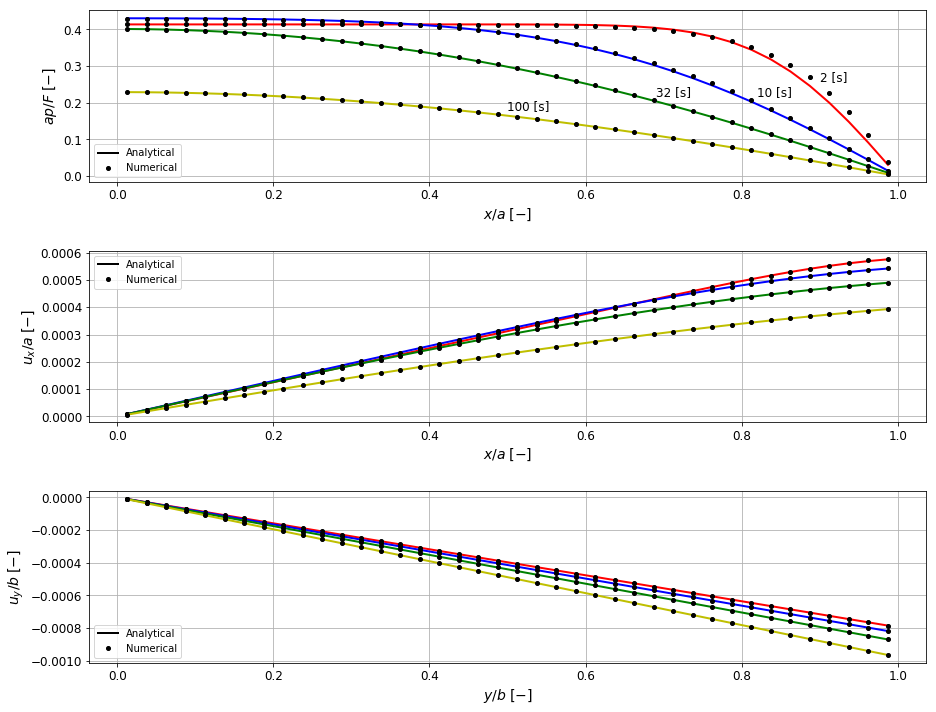

In [21]:
# Creating figure object
fig = plt.figure(figsize=(15,12))

# Assingning one frame to each plot
ax1 = plt.subplot(311)
ax2 = plt.subplot(312)
ax3 = plt.subplot(313)

# Plot the solutions
times_plot = [2,10,32,100]
colors = ['r','b','g','y']
c_ind = 0

for i in times_plot:
    
    # Pressure
    ax1.plot(g.cell_centers[0][0:Nx]/Lx,
             sol_mandel['p'][i]*Lx/F_load,
             color = colors[c_ind],linewidth = 2)  
    ax1.plot(g.cell_centers[0][(Ny-1)*Nx:Ny*Nx]/Lx,
             sol['pressure'][i][0:Nx]*Lx/F_load,
             'ok',markersize = 4)
    
    # Horizontal displacement
    ax2.plot(g.cell_centers[0][0:Nx]/Lx,
             sol_mandel['u_x'][i]/Lx,
             color = colors[c_ind],linewidth = 2)
    ax2.plot(g.cell_centers[0][0:Nx]/Lx,
             sol['displacement'][i][::2][:Nx]/Lx,
             'ok',markersize = 4)
    
    # Vertical displacement
    ax3.plot(g.cell_centers[1][::Nx]/Ly,
             sol_mandel['u_y'][i]/Ly,
             color = colors[c_ind],linewidth = 2)
    ax3.plot(g.cell_centers[1][::Nx]/Ly,
             sol['displacement'][i][1::2][::Nx]/Ly,
             'ok',markersize = 4)
    
    c_ind += 1 # color array increment
    
# Put axis labels
ax1.plot([],[],'-k',linewidth = 2,label = 'Analytical')
ax1.plot([],[],'ok',label = 'Numerical',markersize = 4)
ax1.set_xlabel(r'$x/a \; [-]$',fontsize = 14)
ax1.set_ylabel(r'$ap/F \; [-]$',fontsize = 14)
ax1.grid(True)      
ax1.text(0.9, 0.26, '2 [s]',fontsize=12)
ax1.text(0.82, 0.22, '10 [s]',fontsize=12)
ax1.text(0.69, 0.22, '32 [s]',fontsize=12)
ax1.text(0.5, 0.18, '100 [s]',fontsize=12)
ax1.legend(loc='lower left')
ax1.tick_params(axis='both',which='major',labelsize=12)

ax2.plot([],[],'-k',linewidth = 2,label = 'Analytical')
ax2.plot([],[],'ok',label = 'Numerical',markersize = 4)
ax2.set_xlabel(r'$x/a \; [-]$',fontsize = 14)
ax2.set_ylabel(r'$u_x/a \; [-]$',fontsize = 14)
ax2.grid(True) 
ax2.legend(loc='upper left')
ax2.tick_params(axis='both',which='major',labelsize=12)


ax3.plot([],[],'-k',linewidth = 2,label = 'Analytical')
ax3.plot([],[],'ok',label = 'Numerical',markersize=4)
ax3.set_xlabel(r'$y/b \; [-]$',fontsize = 14)
ax3.set_ylabel(r'$u_y/b \; [-]$',fontsize = 14)
ax3.grid(True) 
ax3.legend(loc='lower left')
ax3.tick_params(axis='both',which='major',labelsize=12)


plt.subplots_adjust(hspace=0.4)
plt.show()


## References
<a id='ref'></a>

[1]: *Mandel, J. (1953). Consolidation des sols (étude mathématique). Geotechnique, 3(7), 287-299.*

[2]: *Abousleiman, Y., Cheng, A. D., Cui, L., Detournay, E., & Roegiers, J. C. (1996). Mandel's problem revisited. Geotechnique, 46(2), 187-195.*

[3]: *Phillips, P. J., & Wheeler, M. F. (2007). A coupling of mixed and continuous Galerkin finite element methods for poroelasticity I: the continuous in time case. Computational Geosciences, 11(2), 131.*

[4]: *Borregales, M., Kumar, K., Radu, F. A., Rodrigo, C., & Gaspar, F. J. (2018). A parallel-in-time fixed-stress splitting method for Biot's consolidation model. arXiv preprint arXiv:1802.00949.*